In [35]:
import torchvision
from tqdm import tqdm
import numpy as np
from utils.transforms import *
import matplotlib.pyplot as plt
import re
from sklearn.cross_decomposition import CCA
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

import random

ModuleNotFoundError: No module named 'xgboost'

In [5]:
with open('local/collected_data_with_crop.txt', 'r') as file:
    # lines = file.readlines()
    data = file.read().strip()
    
epochs_lines = data.split('\n\n\n\n\n\n\n')

In [9]:
ops = ['Bri', 'Col', 'Con', 'Sha', 'Rot', 'She', 'Tra', 'Aut', 'Equ', 'Inv', 'Pos', 'Sol']

In [10]:
def line2parts(line):
    parts = ['']
    for i in range(len(line)):
        if line[i] == ',' and line[i+1] != ' ':
            parts.append('')
        else:
            parts[-1] += line[i]
    
    return parts

def process_part(input_string):

    # Input string
    # input_string = "Pos 0.35 Cut 0.02 crop [0, 9, 17, 31] flip 0"

    # Regular expression to match the pattern
    pattern = r'(\w+)\s(\[.*?\]|\d+\.\d+|\d+)'

    # Find all matches
    matches = re.findall(pattern, input_string)

    # Convert matches to the desired format
    result = [(match[0], eval(match[1])) for match in matches]

    # Print the result
    return result


def intersection_over_union(boxA, boxB):
    # Extract the coordinates of the two boxes
    topA, leftA, bottomA, rightA = boxA
    topB, leftB, bottomB, rightB = boxB
    
    # Determine the coordinates of the intersection rectangle
    interTop = max(topA, topB)
    interLeft = max(leftA, leftB)
    interBottom = min(bottomA, bottomB)
    interRight = min(rightA, rightB)
    
    # Compute the area of the intersection rectangle
    interWidth = max(0, interRight - interLeft)
    interHeight = max(0, interBottom - interTop)
    interArea = interWidth * interHeight
    
    # Compute the area of both bounding boxes
    boxAArea = (rightA - leftA) * (bottomA - topA)
    boxBArea = (rightB - leftB) * (bottomB - topB)
    
    # Compute the Intersection over Union
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou


def lvl2strength(trans, lvl):
    if trans in ['Bri', 'Col', 'Con', 'Sha', 'Rot', 'She', 'Tra']:
        val = 2*lvl - 1
    elif trans in ['Aut', 'Equ', 'Inv']:
        val = 1
    elif trans == 'Pos':
        val = 0.8*lvl + 0.2
    elif trans == 'Sol':
        val = 1 - lvl/256
    else:
        return trans, lvl
    return trans, val


def parts2vector(x1_x2_sim):
    x1, x2, sim = x1_x2_sim
    
    vec1, vec2 = np.zeros((len(ops),)), np.zeros((len(ops),))
    
    x1 = list(  map( lambda e: lvl2strength(e[0], e[1]) , x1 )  )
    x2 = list(  map( lambda e: lvl2strength(e[0], e[1]) , x2 )  )
    
    for trans, val in x1:
        if trans in ops:
            vec1[ops.index(trans)] = val
    
    for trans, val in x2:
        if trans in ops:
            vec2[ops.index(trans)] = val
        
    # print(vec1, vec2)
    # return  sum(abs(vec1)) + sum(abs(vec2))
    
    iou = intersection_over_union(x1[-2][1], x2[-2][1])

    return  np.concatenate((
        # abs(vec1 - vec2),
        vec1, vec2,  
        [1-iou]
    ))


# parts2vector(x1_x2_sim[0])

In [12]:
def epoch2vectors(epoch, samples=None):
    lines = epoch.strip().split('\n')
    if samples is not None:
        lines = random.sample(lines, samples)
    
    random.shuffle(lines)

    x1_x2_sim = []
    for line in lines:
        x1, x2, sim = line2parts(line)
        x1 = process_part(x1)
        x2 = process_part(x2)
        x1_x2_sim.append((x1, x2, float(sim)))
            
    vectors = list(map(parts2vector, x1_x2_sim))
    sims = list(map(lambda e:e[2], x1_x2_sim))
    
    return vectors, sims

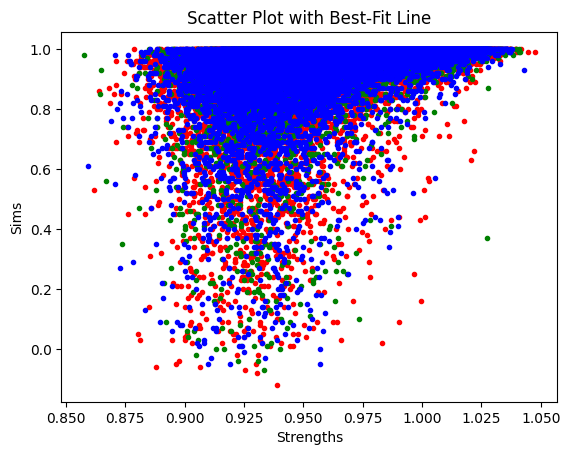

In [34]:
# for epoch in tqdm(epochs_lines):

i = 700
vec_i, sims_i = epoch2vectors(epochs_lines[i])
vec_j, sims_j = epoch2vectors(epochs_lines[i+1])
    
    
# X = np.array(strengths)
# Y = np.array(sims)

s = 30000
X_train_i, y_train_i, X_test_i, y_test_i = vec_i[:s], sims_i[:s], vec_i[s:], sims_i[s:]
# X_train_j, y_train_j, X_test_j, y_test_j = vec_j[:s], sims_j[:s], vec_j[s:], sims_j[s:]

# cca = CCA(n_components=1)  # We only need 1 pair of canonical variates
# cca.fit(X, Y)
# x_weights = cca.x_weights_.reshape(-1)  # Reshape to a 1D vector
# f_of_x = X.dot(x_weights)


# model = LinearRegression()
model = MLPRegressor(hidden_layer_sizes=(512), max_iter=1000, random_state=42, activation='relu')
model.fit(X_train_i, y_train_i)


pred_train_i = model.predict(X_train_i)
pred_test_i  = model.predict(X_test_i)
pred_j  = model.predict(vec_j)

# print('train loss:', abs(y_train_i - pred_train_i).mean())
# print('test loss:', abs(y_test_i - pred_test_i).mean())
# print("Correlation train:", np.corrcoef(pred_train_i, y_train_i)[0, 1])
# print("Correlation test:", np.corrcoef(pred_test_i, y_test_i)[0, 1])


plt.scatter(pred_j, sims_j, marker='.', c='red', alpha=1)
plt.scatter(pred_test_i, y_test_i, marker='.', c='green', alpha=1)
plt.scatter(pred_train_i, y_train_i, marker='.', c='blue', alpha=1)

# coefficients = np.polyfit(f_of_x, sims, 1)
# poly = np.poly1d(coefficients)
# fit_line = poly(f_of_x)

# plt.plot(f_of_x, fit_line, color='red')

plt.xlabel('Strengths')
plt.ylabel('Sims')
plt.title('Scatter Plot with Best-Fit Line')
plt.show()

In [ ]:
# np.corrcoef(f_of_x, Y)[0, 1]

In [ ]:
dataset = torchvision.datasets.CIFAR10('./dataset/cifar10/', train=True)

In [ ]:
dataset[0][0] == TranslateX(dataset[0][0], 0)

True

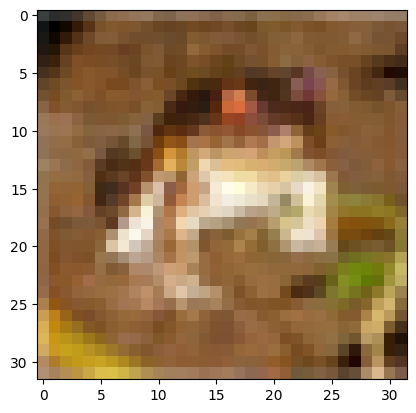

In [ ]:
plt.imshow(TranslateX(dataset[0][0], 0)) 

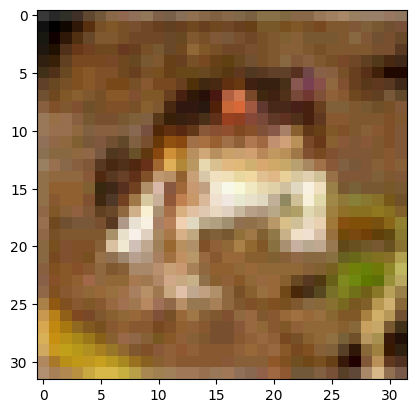

In [ ]:
plt.imshow(Posterize(dataset[0][0], 5))